# HCDN Streamflow Analysis for Groundwater Signals

In [2]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from operator import itemgetter
import numpy as np
import scipy.stats as stats
import rioxarray as rioxr
from rasterio.enums import Resampling


import datetime as dt
import matplotlib.pyplot as plt
import shapely
import contextily as cx
import seaborn as sns 
from dataretrieval import nwis
import rioxarray as rxr
import statsmodels.api as sm
import datetime as dt



In [39]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Column Dictionary

In [3]:
column_dict = {'09034900': 'BOBTAIL CREEK NEAR JONES PASS, CO.',
                '09035900': 'SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.',
                '09035800': 'DARLING CREEK NEAR LEAL, CO.',
                '09047700': 'KEYSTONE GULCH NEAR DILLON, CO.',
                # '09066000': 'BLACK GORE CREEK NEAR MINTURN, CO.',
                # '09065500': 'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
                # '09066200': 'BOOTH CREEK NEAR MINTURN, CO.',
                '09066300': 'MIDDLE CREEK NEAR MINTURN, CO.',
                '09081600': 'CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.',
                '09107000': 'TAYLOR RIVER AT TAYLOR PARK, CO.',
                # '09110000': 'TAYLOR RIVER AT ALMONT, CO.',
                '09112500': 'EAST RIVER AT ALMONT CO.',
                '09115500': 'TOMICHI CREEK AT SARGENTS, CO.',
                '09119000': 'TOMICHI CREEK AT GUNNISON, CO.',
                '09124500': 'LAKE FORK AT GATEVIEW, CO.',
                # '09125000': 'CURECANTI CREEK NEAR SAPINERO, CO.',
                '09128500': 'SMITH FORK NEAR CRAWFORD, CO.',
                '09132500': 'NORTH FORK GUNNISON RIVER NEAR SOMERSET, CO.',
                '09146200': 'UNCOMPAHGRE RIVER NEAR RIDGWAY, CO.',
                '09147500': 'UNCOMPAHGRE RIVER AT COLONA, CO.',
                '09165000': 'DOLORES RIVER BELOW RICO, CO.',
                # '09168100': 'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
                # '09239500': 'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
                '09241000': 'ELK RIVER AT CLARK, CO.',
                '09245000': 'ELKHEAD CREEK NEAR ELKHEAD, CO.',
                # '09250000': 'MILK CREEK NEAR THORNBURGH, CO.',
                '09304500': 'WHITE RIVER NEAR MEEKER, CO.',
                '09352900': 'VALLECITO CREEK NEAR BAYFIELD, CO.',
                '09361500': 'ANIMAS RIVER AT DURANGO, CO.'}


### Load UCRB and HCDN Stations

In [4]:
# Get UCRB stations
ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_co_gdf_final.json')

# Add 0 to the station  ID
ucrb_hcdn_stations['STAID'] = ['0'+str(id) for id in ucrb_hcdn_stations['STAID']]
# ucrb_hcdn_stations = ucrb_hcdn_stations[~ucrb_hcdn_stations['STAID'].isin(['09168100','09250000'])]

# Get basin polygons
basins = gpd.read_file(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\sublimation_of_snow\data\bas_nonref_WestMnts.shp")

# Create new crs and drop one of the columns
ucrb_hcdn_co_gdf = ucrb_hcdn_stations.to_crs(basins.crs)
ucrb_hcdn_co_gdf = ucrb_hcdn_co_gdf.drop('index_right',axis=1)

# Combine to find locations of sites within basins
ucrb_hcdn_combined = gpd.sjoin(basins,ucrb_hcdn_co_gdf)

In [5]:
idx = []
for station in ucrb_hcdn_combined['STANAME'].unique():
    tmp = ucrb_hcdn_combined[ucrb_hcdn_combined['STANAME']==station]
    idx.append(tmp.loc[tmp['AREA'].idxmin()])

In [6]:
# Get the smallest basin that matches each gage location
ucrb_hcdn_basins = gpd.GeoDataFrame(idx, crs=basins.crs)
# Change the crs
ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs(epsg='4326')


In [7]:
idx_gages = []
for gage in ucrb_hcdn_basins.GAGE_ID:
    tmp = ucrb_hcdn_basins[ucrb_hcdn_basins.GAGE_ID == gage]
    if tmp['DRAIN_SQKM'].idxmax() not in idx_gages:
        idx_gages.append(tmp['DRAIN_SQKM'].idxmax())

In [8]:
ucrb_hcdn_basins_filtered = ucrb_hcdn_basins.loc[idx_gages].reset_index()
# ucrb_hcdn_basins_filtered.to_file('./ucrb_hcdn_co_polygons_final.json')

### Load in HCDN Streamflow from filtered gages

In [8]:
# ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_co_gdf_final.json')
# ucrb_hcdn_stations['geometry'] = gpd.GeoSeries(ucrb_hcdn_stations['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
# ucrb_hcdn_stations = ucrb_hcdn_stations.set_crs(epsg='4326')

station_ids = list(column_dict.keys())

hcdn_streamflow_df = nwis.get_dv(sites=station_ids, start='1935-10-01', end='2021-09-30')


Create Xarray dataset

In [9]:
df = hcdn_streamflow_df[0]['00060_Mean'].reset_index()

df['datetime']=[d.date() for d in df['datetime']]
df['datetime']= pd.to_datetime(df['datetime'])
df = df.set_index(['site_no','datetime'])
hcdn_q_ds = df.to_xarray()

In [10]:
# hcdn_q_ds.to_netcdf('./hcdn_q_data.nc')

Convert to April to September Sum

In [9]:
hcdn_q_ds = xr.open_dataset('./hcdn_q_data.nc')
hcdn_q_spring_summer_ds = hcdn_q_ds.where(hcdn_q_ds.datetime.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_sum_ds = hcdn_q_spring_summer_ds.groupby('datetime.year').sum()

In [10]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days



### Filters for Norther, Central, Southern Basins

In [11]:
northern_names = ['09034900', '09035900',  '09047700', '09066000',
       '09065500', '09066200', '09066300', '09239500', 
        '09304500'] # removed '09035800','09241000'
central_names = ['09081600',  '09112500',  '09132500'] # removed '09115500','09125000', '09128500','09110000','09107000',
southern_names = ['09119000', '09124500', '09146200', '09147500', '09165000',
       '09352900', '09361500']

In [12]:
# fig, axs = plt.subplots(nrows=len(northern_names))
df = hcdn_q_ds.to_dataframe().reset_index().set_index('datetime')
df_list= [df[df['site_no']==site].rename(columns={'00060_Mean':site})[site] for site in df['site_no'].unique()]
streamflow_df = pd.concat(df_list, axis=1)
# add dowy to data 
# Create an empty array with the same length as the day of water year
dowy = np.zeros(len(streamflow_df.index))
for i,date in enumerate(streamflow_df.index):
    dowy[i] = date2DOWY(date)
streamflow_df['dowy']=dowy
streamflow_df['WY'] = streamflow_df.index.year.where(streamflow_df.index.month<10, streamflow_df.index.year+1)

### Compute Baseflow Index

In [13]:
bfi = ((streamflow_df.groupby('WY').min()/streamflow_df.groupby('WY').mean()).mean()*100).drop('dowy')

### Plot Lag-1 Autocorrelation against Flow Percentile

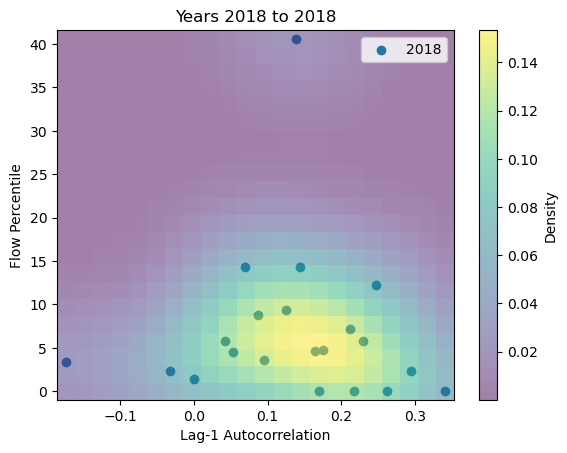

In [14]:
flow_sums_hcdn = streamflow_df.groupby('WY').sum().drop('dowy', axis=1)
flow_sums_hcdn=flow_sums_hcdn[flow_sums_hcdn>0]
from scipy.stats import gaussian_kde
dry0 = [1988,1989,1990,1991]
dry1 = [2000,2001,2002,2003,2004]
# dry2 = [2012]
dry3 = [2018,2020,2021]
wet1 = [1993,1994,1995,1996,1997]
fig, ax = plt.subplots()
for period in [[2018]]:#,dry1,dry3,wet1]: [2002,2018,1995,2019,1991,1998]
    for i,y in enumerate(period):

        year=y
        lag_1_autocorr = {}
        flow_percentile = {}
        for site in flow_sums_hcdn.columns:
            lag_1_autocorr[site] = sm.tsa.acf(flow_sums_hcdn[site].dropna())[1]
            if year in flow_sums_hcdn[site].dropna().index:
                flow_percentile[site] = (flow_sums_hcdn[site].dropna().rank(pct=True)*100).loc[year]
            else:
                flow_percentile[site] = np.nan
        if i == 0:
            lag_1_df = pd.DataFrame(pd.Series(lag_1_autocorr))
            lag_1_df = lag_1_df.rename(columns={0:f'lag_1_{year}'})
            flow_percentile_df = pd.DataFrame(pd.Series(flow_percentile))
            flow_percentile_df = flow_percentile_df.rename(columns={0:f'flow_percentile_{year}'})
        else:
            lag_1_df[f'lag_1_{year}'] = lag_1_autocorr.values()
            flow_percentile_df[f'flow_percentile_{year}'] = flow_percentile.values()
    x = np.nan_to_num(lag_1_df.values.ravel())
    y = np.nan_to_num(flow_percentile_df.values.ravel())

    ax.scatter(x,y, label=year)
    ax.set_ylabel('Flow Percentile')
    # ax.set_ylim(0,100)
    ax.set_xlabel('Lag-1 Autocorrelation')
    ax.set_title(f'Lag-1 vs Flow percentile for 2002 for 26 basins in UCRB')
    ax.legend()

    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():500**0.5*1j,y.min():y.max():500**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # ax.set_ylim(0,100)
    h = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.5,)
    # ax.axhline(np.median(y),color='r',ls='--', label='Period Median')
    ax.legend()
    ax.set_title(f'Years {period[0]} to {period[-1]}')
    plt.colorbar(h, label='Density')
    

### Plot Discharge for Different Basins over Dry Periods

Text(-0.02, 0.5, 'Discharge (m$^3$/s)')

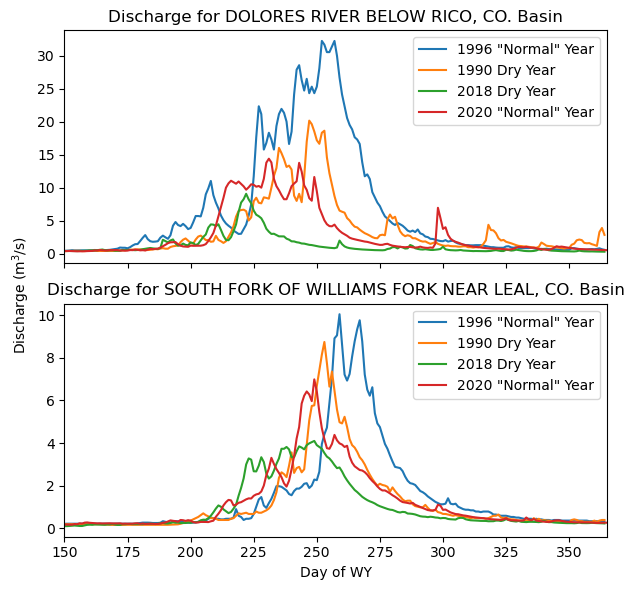

In [493]:
fig, axs = plt.subplots(nrows=2, figsize=(6,6), tight_layout=True, sharex=True)
labels = ['Flashier', 'GW Influenced']
for i,site in enumerate(['09165000','09035900']):
    ax=axs[i]
    min_year = streamflow_df[site].dropna().index.year.min()
    max_year = streamflow_df[site].dropna().index.year.max()
    # (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).plot(ax=ax, label=f'{min_year} to {max_year} Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(1991,10,1):dt.date(1978,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(1989,10,1):dt.date(1990,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2017,10,1):dt.date(2018,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2019,10,1):dt.date(2020,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, legend=False)
    ax.legend([f'1996 "Normal" Year',
                    '1990 Dry Year',
                    '2018 Dry Year',
                    '2020 "Normal" Year'])
    ax.set_title(f'Discharge for {column_dict[site]} Basin')
    # ax.set_ylabel('Discharge (cfs)')
    ax.set_xlabel('Day of WY')
    ax.set_xlim(150,365)
fig.text(-0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

Text(-0.02, 0.5, 'Discharge (m$^3$/s)')

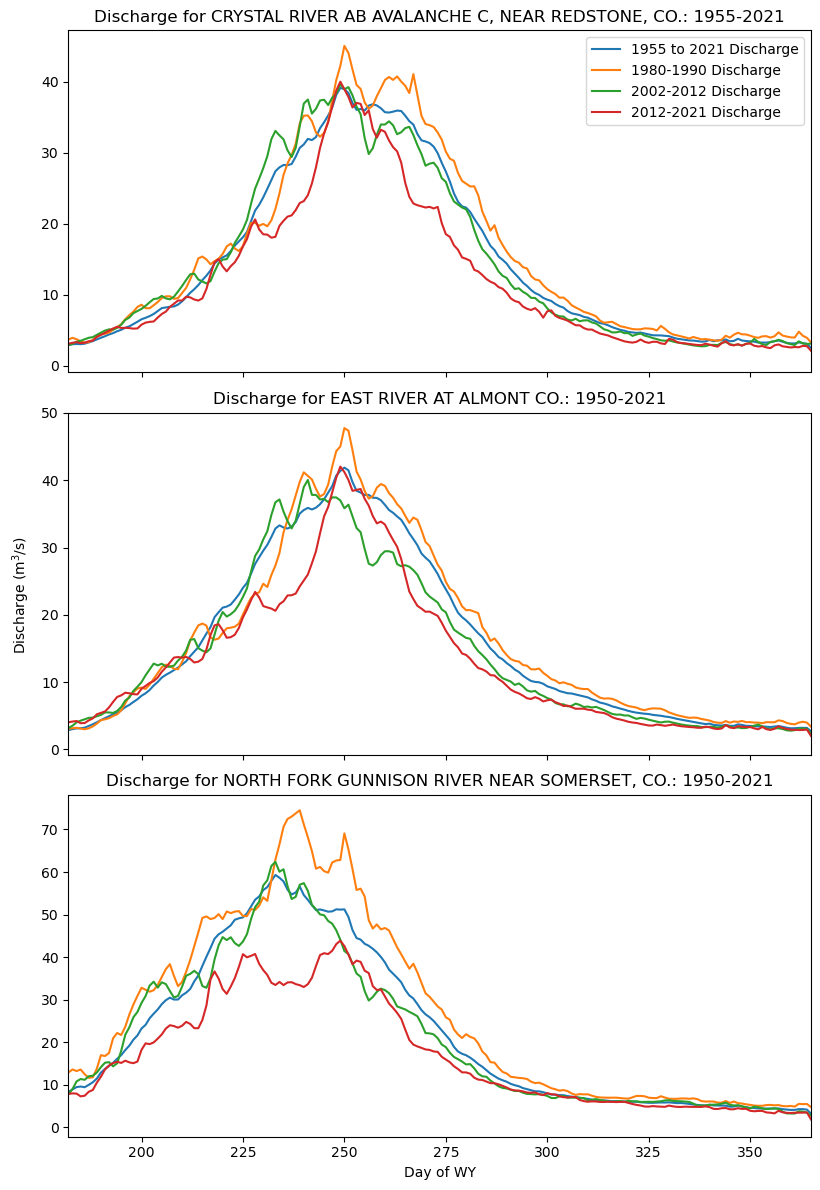

In [ ]:
fig, axs = plt.subplots(nrows=len(central_names), figsize=(8,12), tight_layout=True, sharex=True)
for i,site in enumerate(central_names):
    ax=axs[i]
    min_year = streamflow_df[site].dropna().index.year.min()
    max_year = streamflow_df[site].dropna().index.year.max()
    (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).plot(ax=ax, label=f'{min_year} to {max_year} Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(1980,10,1):dt.date(1984,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='1983-1987 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2000,10,1):dt.date(2004,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2000-2004 Discharge',legend=False)
    # (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2015,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2012-2015 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2018,10,1):dt.date(2022,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2018-2022 Discharge',legend=False)
    ax.set_title
    if i == 0:
        ax.legend([f'{min_year} to {max_year} Discharge',
                    '1980-1990 Discharge',
                    '2002-2012 Discharge',
                    '2012-2021 Discharge'])
    ax.set_title(f'Discharge for {column_dict[site]}: {min_year}-{max_year}')
    # ax.set_ylabel('Discharge (cfs)')
    ax.set_xlabel('Day of WY')
    ax.set_xlim(182,365)
fig.text(-0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

### Plot Lag-1 Autocorrelation and BFI against CV

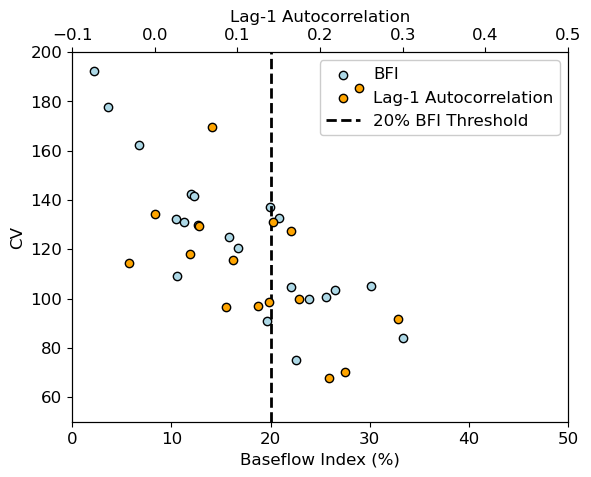

In [40]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
time_filter = streamflow_df.loc[dt.date(2017,10,1):dt.date(2021,9,30)]

fig,ax = plt.subplots()
ax2= ax.twiny()
ax2.scatter(lag_1_autocorr.values(),
            time_filter.groupby(time_filter.index.month).mean().apply(cv).drop(['dowy','WY']), 
            color='orange',
            ec='k')

ax.scatter(bfi.values,
           streamflow_df.groupby(streamflow_df.index.month).mean().apply(cv).drop(['dowy','WY']), 
           color='lightblue',
           ec='k', 
           label='BFI',
           zorder=0)
ax.scatter([],[], 
           color='orange',
           ec='k', 
           label='Lag-1 Autocorrelation')
ax.set_ylabel('CV')
ax.set_xlabel('Baseflow Index (%)')
ax.set_ylim(50,200)
ax.set_xlim(0,50)
ax.axvline(20, label='20% BFI Threshold', lw=2, color='k', ls='--')


ax2.set_xlabel('Lag-1 Autocorrelation')
ax2.set_xlim(-0.1,0.5)
ax.legend(framealpha=1, loc='upper right')


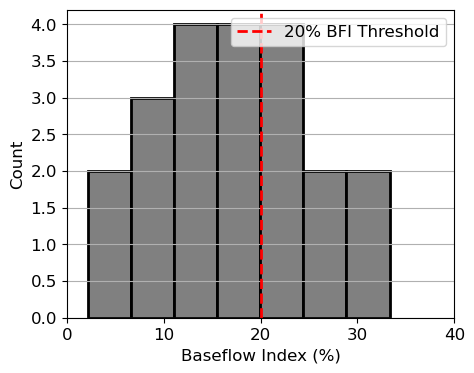

In [54]:
fig, ax = plt.subplots(figsize=(5,4))
bfi.hist(bins=7,ax=ax, ec='k',lw=2, color='grey')
ax.axvline(20,ls='--',color='r',lw=2, label='20% BFI Threshold')
ax.set_xlabel('Baseflow Index (%)')
ax.set_ylabel('Count')
ax.grid(axis='x')
ax.set_xlim(0,40)
ax.legend()

### Compare Low and High Lag-1 Autocorrelated Basins WY Flows

Text(-0.02, 0.5, 'Discharge (m$^3$/s)')

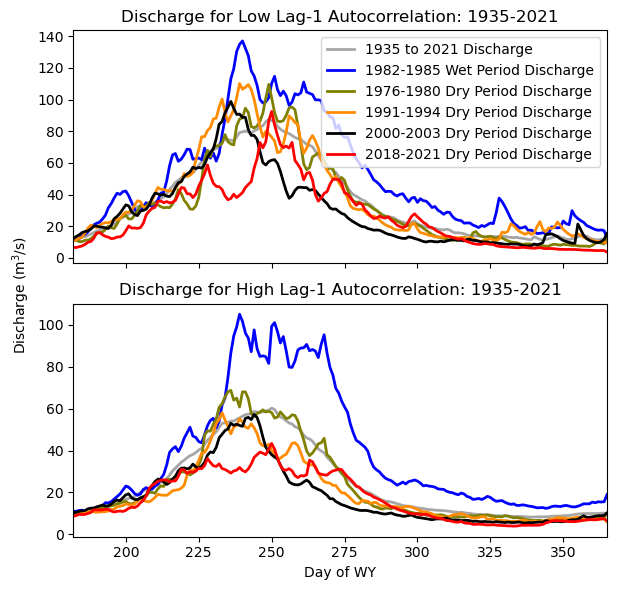

In [115]:
fig, axs = plt.subplots(nrows=len(['09361500','09304500']), figsize=(6,6), tight_layout=True, sharex=True)
labels=['Low Lag-1 Autocorrelation', 'High Lag-1 Autocorrelation']
for i,site in enumerate(['09361500','09304500']):
    ax=axs[i]
    min_year = streamflow_df[site].dropna().index.year.min()
    max_year = streamflow_df[site].dropna().index.year.max()
    (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).plot(ax=ax, label=f'{min_year} to {max_year} Discharge',legend=False,color='gray', lw=2, alpha=0.7)
    (streamflow_df[[site,'dowy']].loc[dt.date(1981,10,1):dt.date(1985,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='1981-1984 Discharge',legend=False,color='blue',lw=2)
    (streamflow_df[[site,'dowy']].loc[dt.date(1975,10,1):dt.date(1979,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='1974-1978 Discharge',legend=False,color='olive',lw=2,)
    (streamflow_df[[site,'dowy']].loc[dt.date(1990,10,1):dt.date(1994,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2012-2015 Discharge',legend=False,color='darkorange',lw=2,)
    (streamflow_df[[site,'dowy']].loc[dt.date(1999,10,1):dt.date(2005,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2012-2015 Discharge',legend=False,color='k',lw=2)
    (streamflow_df[[site,'dowy']].loc[dt.date(2017,10,1):dt.date(2021,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2018-2021 Discharge',legend=False,color='red',lw=2)
    ax.set_title
    if i == 0:
        ax.legend([f'{min_year} to {max_year} Discharge',
                    '1982-1985 Wet Period Discharge',
                    '1976-1980 Dry Period Discharge',
                    '1991-1994 Dry Period Discharge',
                    '2000-2003 Dry Period Discharge',
                    '2018-2021 Dry Period Discharge'])
    ax.set_title(f'Discharge for {labels[i]}: {min_year}-{max_year}')
    # ax.set_ylabel('Discharge (cfs)')
    ax.set_xlabel('Day of WY')
    ax.set_xlim(182,365)
fig.text(-0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

### Bar Plot Comparing Low and High Lag-1 Autocorrelated Flows

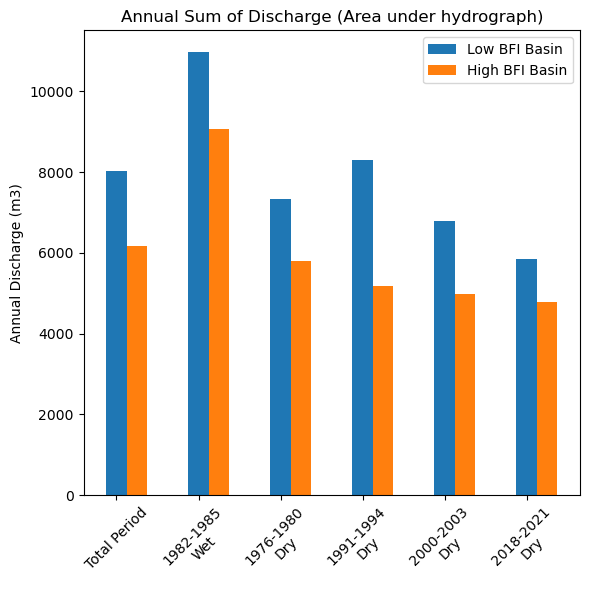

In [116]:
fig, ax= plt.subplots(nrows=1, figsize=(6,6), tight_layout=True, sharex=True)
x1=[0,1,2,3,4,5]
x2 = [0.25,1.25,2.25,3.25,4.25,5.25]
location = [x1,x2]
labels=['Low BFI Basin', 'High BFI Basin']
for i,site in enumerate(['09361500','09304500']):

    ax.bar(x=location[i],
        height=[
            (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1981,10,1):dt.date(1985,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1975,10,1):dt.date(1979,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1990,10,1):dt.date(1994,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1999,10,1):dt.date(2005,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(2017,10,1):dt.date(2021,9,30)].groupby('dowy').mean()*0.0283).sum().values[0]
        ], width=0.25, label=labels[i])
        # yerr=[
        #     np.sqrt((streamflow_df[[site,'dowy']].groupby('dowy').var()*0.0283).mean().values[0]),
        #     np.sqrt((streamflow_df[[site,'dowy']].loc[dt.date(1981,10,1):dt.date(1985,9,30)].groupby('dowy').var()*0.0283).mean().values[0]),
        #     np.sqrt((streamflow_df[[site,'dowy']].loc[dt.date(1975,10,1):dt.date(1979,9,30)].groupby('dowy').var()*0.0283).mean().values[0]),
        #     np.sqrt((streamflow_df[[site,'dowy']].loc[dt.date(1990,10,1):dt.date(1994,9,30)].groupby('dowy').var()*0.0283).mean().values[0]),
        #     np.sqrt((streamflow_df[[site,'dowy']].loc[dt.date(1999,10,1):dt.date(2005,9,30)].groupby('dowy').var()*0.0283).mean().values[0]),
        #     np.sqrt((streamflow_df[[site,'dowy']].loc[dt.date(2017,10,1):dt.date(2021,9,30)].groupby('dowy').var()*0.0283).mean().values[0])
        #  ])
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([f'Total Period',
                    '1982-1985\nWet',
                    '1976-1980\nDry',
                    '1991-1994\nDry',
                    '2000-2003\nDry',
                    '2018-2021\nDry'], rotation=45)
    ax.set_title(f'Annual Sum of Discharge (Area under hydrograph)')
    ax.set_ylabel('Annual Discharge (m3)')
    ax.legend()
# fig.text(-0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

# Precipiation vs Q Analysis
### Pull in PRISM Data

In [17]:
import geopandas as gpd
ucrb_hcdn_basins_filtered = gpd.read_file('ucrb_hcdn_co_polygons_final.json',crs=4326)
two_basins = ucrb_hcdn_basins_filtered[ucrb_hcdn_basins_filtered['STAID'].isin(['09304500','09361500'])]

prism_anomaly = pd.read_csv('ucrb_hcdn_seasonal_prism_anomalies.csv', index_col=0)
# prism_anomaly=prism_anomaly[[column_dict['09304500'],column_dict['09361500']]]

In [19]:
# Download PRISM precipitation from 4km product 
outpath = '../../data/PRISM/PRISM_ppt_stable_4km/'
files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
prism_list = []
dates = []
for file in files:
       dates.append(file[-14:-8]+'01')
       tmp = rioxr.open_rasterio(os.path.join(outpath,file))
       prism_list.append(tmp)
prism_normals_ds = xr.concat(prism_list, dim='band')
prism_normals_ds = prism_normals_ds.rename({'band':'month'})


In [20]:
# Assign dates to coordinates
prism_normals_ds = prism_normals_ds.assign_coords({
         'month': pd.to_datetime(dates,format='%Y%m%d')}) 

#### Annual PRISM

In [48]:
# White River PRISM values 
white_river_prism = prism_normals_ds.rio.clip(two_basins[two_basins['STAID']=='09304500'].geometry)
WY = white_river_prism.month.dt.year.where(white_river_prism.month.dt.month<10, white_river_prism.month.dt.year+1)
white_river_prism['WY'] = WY
white_river_prism_mean = white_river_prism.where(white_river_prism>=0).sum(dim=['x','y']).groupby(white_river_prism.WY).sum()/10

# Animas PRISM Values
animas_river_prism = prism_normals_ds.rio.clip(two_basins[two_basins['STAID']=='09361500'].geometry)
animas_river_prism['WY'] = WY
animas_river_prism_mean = animas_river_prism.where(animas_river_prism>=0).sum(dim=['x','y']).groupby(animas_river_prism.WY).sum()/10

# # Add to dataframe
prism_anomaly = pd.DataFrame({
    'WHITE RIVER NEAR MEEKER, CO.':white_river_prism_mean.values,
    'ANIMAS RIVER AT DURANGO, CO.':animas_river_prism_mean.values
}, index=white_river_prism_mean.WY)


#### Seasonal PRISM

In [23]:
# Seasonal Precipitation Plot
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.month.dt.days_in_month

    # Calculate the weighted average
    return (ds).resample(month='QS-JAN').mean() * 3
def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('month.month').mean("month")
    ds_std = ds.groupby('month.month').std("month")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("month.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies
# White River PRISM values 
white_river_prism = prism_normals_ds.rio.clip(two_basins[two_basins['STAID']=='09304500'].geometry)
WY = white_river_prism.month.dt.year.where(white_river_prism.month.dt.month<10, white_river_prism.month.dt.year+1)
white_river_prism['WY'] = WY
white_river_prism_season = season_mean(white_river_prism.where(white_river_prism>=0).sum(dim=['x','y']))/10

# Animas PRISM Values
animas_river_prism = prism_normals_ds.rio.clip(two_basins[two_basins['STAID']=='09361500'].geometry)
animas_river_prism['WY'] = WY
animas_river_prism_season = season_mean(animas_river_prism.where(animas_river_prism>=0).sum(dim=['x','y']))/10
animas_river_prism_season['WY'] = animas_river_prism_season.month.dt.year.where(animas_river_prism_season.month.dt.month<10, animas_river_prism_season.month.dt.year+1)


### Pull in SWE Data as needed

In [197]:
# Fill in missing SWE values
cascade_df = pd.read_csv('../../data/cascade_2_sntl.csv',index_col=0)['Snow Water Equivalent (in) Start of Day Values'].dropna()
cascade_df.index = pd.to_datetime(cascade_df.index)
cascade_df.name = 'WTEQ'

# Add to snotel dataset
sntl_ds = xr.open_dataset('./hcdn_closest_sntl_20220930_corr.nc')
# Use this if needed
# sntl_df = sntl_ds.to_dataframe()
# sntl_df.loc[(slice('1990-10-1','2022-09-30'),'387:CO:SNTL'),'WTEQ'] = cascade_df.values
# sntl_ds = sntl_df.to_xarray()
# sntl_ds.to_netcdf('./hcdn_closest_sntl_20220930_corr.nc')

### Download NARR precip for comparison

In [144]:
# Download NARR precipitation product for comparison
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
narr_p_ds = rxr.open_rasterio('../../data/acpcp.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
narr_p_ds = narr_p_ds.rio.write_crs(lcc_proj)

# Create NARR precip values for the White River
narr_p_ds_clipped = narr_p_ds.rio.clip(two_basins[two_basins['STAID']=='09304500'].to_crs(lcc_proj).geometry)
narr_p_ds_ma = narr_p_ds_clipped.where(narr_p_ds_clipped['acpcp']!=9.96921e+36)*1000

WY = narr_p_ds_ma.time.dt.year.where(narr_p_ds_ma.time.dt.month<10, narr_p_ds_ma.time.dt.year+1)
narr_p_ds_ma['WY'] = WY
white_narr_p_ds_ma_mean = narr_p_ds_ma.where(narr_p_ds_ma>=0).sum(dim=['x','y']).groupby('WY').sum()

# Create NARR precip values for the Animas River
narr_p_ds_clipped = narr_p_ds.rio.clip(two_basins[two_basins['STAID']=='09361500'].to_crs(lcc_proj).geometry)
narr_p_ds_ma = narr_p_ds_clipped.where(narr_p_ds_clipped['acpcp']!=9.96921e+36)*1000

WY = narr_p_ds_ma.time.dt.year.where(narr_p_ds_ma.time.dt.month<10, narr_p_ds_ma.time.dt.year+1)
narr_p_ds_ma['WY'] = WY
animas_narr_p_ds_ma_mean = narr_p_ds_ma.where(narr_p_ds_ma>=0).sum(dim=['x','y']).groupby('WY').sum()

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rioxarray\_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


### Slice Data to timeseries

In [21]:
# prism_anomaly.loc[1981:2022,'WHITE_NARR'] = white_narr_p_ds_ma_mean.sel(WY=slice(1981,2022))['acpcp'].values
# prism_anomaly.loc[1981:2022,'ANIMAS_NARR'] = animas_narr_p_ds_ma_mean.sel(WY=slice(1981,2022))['acpcp'].values

### Bar Plot of Q, P and runoff Ratios Using Seasonal Anomalies

TypeError: cannot do slice indexing on Index with these indexers [1981] of type int

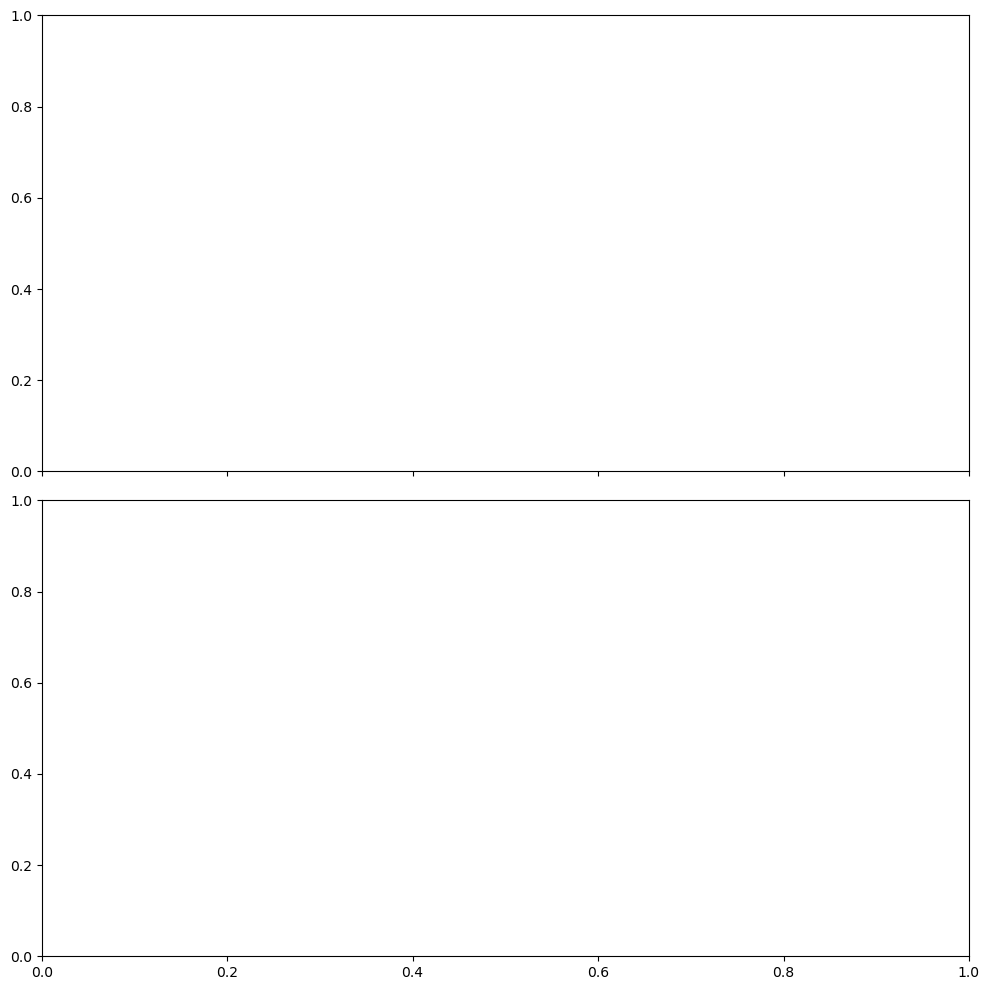

In [24]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10), tight_layout=True, sharex=True)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
x1=[0,1,2,3,4,5,6]
x2 = [0.15,1.15,2.15,3.15,4.15,5.15,6.15]
x3 = [0.3,1.3,2.3,3.3,4.3,5.3,6.3]
x4 = [0.45,1.45,2.45,3.45,4.45,5.45,6.45]
labels=['Low BFI Basin', 'High BFI Basin']
sntls = ['387:CO:SNTL','378:CO:SNTL']
# sntl_data = sntl_ds.sel(Location=['387:CO:SNTL','378:CO:SNTL']).groupby(sntl_ds.Date.dt.year).max()['WTEQ']
narr_cols = ['ANIMAS_NARR','WHITE_NARR']
location = [x1,x2,x3,x4]
for i,site in enumerate(['09361500','09304500']):
    streamflow_means = [
            (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1981,10,1):dt.date(1985,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1976,10,1):dt.date(1979,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1986,10,1):dt.date(1991,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1999,10,1):dt.date(2004,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2015,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(2017,10,1):dt.date(2021,9,30)].groupby('dowy').mean()*0.0283).sum().values[0]
        ]
    prism_mean = [
            prism_anomaly[column_dict[site]].mean(),
            (prism_anomaly[column_dict[site]].loc[1981:1985]).mean(),
            (prism_anomaly[column_dict[site]].loc[1977:1979]).mean(),
            (prism_anomaly[column_dict[site]].loc[1987:1991]).mean(),
            (prism_anomaly[column_dict[site]].loc[2000:2004]).mean(),
            (prism_anomaly[column_dict[site]].loc[2012:2015]).mean(),
            (prism_anomaly[column_dict[site]].loc[2018:2021]).mean()
        ]
    p_over_q_prism = np.array(streamflow_means)/np.array(prism_mean)
    # narr_mean = [
    #         prism_anomaly[narr_cols[i]].mean(),
    #         (prism_anomaly[narr_cols[i]].loc[1982:1985]).mean(),
    #         (prism_anomaly[narr_cols[i]].loc[1976:1979]).mean(),
    #         (prism_anomaly[narr_cols[i]].loc[1987:1991]).mean(),
    #         (prism_anomaly[narr_cols[i]].loc[1999:2004]).mean(),
    #         (prism_anomaly[narr_cols[i]].loc[2012:2015]).mean(),
    #         (prism_anomaly[narr_cols[i]].loc[2018:2022]).mean()
    #     ]
    # sntl_mean = [
    #         sntl_data.loc[dict(Location=sntls[i])].mean(),
    #         (sntl_data.loc[dict(Location=sntls[i], year=slice(1982,1985))]).mean(),
    #         (sntl_data.loc[dict(Location=sntls[i], year=slice(1976,1979))]).mean(),
    #         (sntl_data.loc[dict(Location=sntls[i], year=slice(1990,1994))]).mean(),
    #         (sntl_data.loc[dict(Location=sntls[i], year=slice(2000,2004))]).mean(),
    #         (sntl_data.loc[dict(Location=sntls[i], year=slice(2012,2015))]).mean(),
    #         (sntl_data.loc[dict(Location=sntls[i], year=slice(2018,2022))]).mean()
        # ]
    # p_over_q_narr = np.array(streamflow_means)/np.array(narr_mean)
    # create plot for each site
    ax=axs[i]
    # ax2 = ax.twinx()                    
    # ax2.bar(x=location[3],
    #     height=sntl_mean, width=0.15, label='Mean April 1 SWE', color=CB_color_cycle[0])

    q_bar = ax.bar(x=location[1],
        height=streamflow_means, width=0.15, label=labels[i],color=CB_color_cycle[1])

    prism_bar = ax.bar(x=location[2],
        height=prism_mean, width=0.15, label='PRISM P * Basin Area',color=CB_color_cycle[2])

    # narr_bar = ax.bar(x=location[2],
    #     height=narr_mean, width=0.15, label='NARR Basin Area Precip',color=CB_color_cycle[3])

    # sntl_bar = ax.bar(x=location[3],
    #     height=np.zeros_like(narr_mean), label='Mean April 1 SWE',color=CB_color_cycle[0])

    # Put Q/P labels over each bar
    ax.bar_label(prism_bar, labels=np.round(p_over_q_prism,2), rotation=90)
    # ax.bar_label(narr_bar, labels=np.round(p_over_q_narr,2), rotation=90)
    ax.set_xticks([0.3,1.3,2.3,3.3,4.3,5.3,6.3])
    ax.set_xticklabels([f'Total Period',
                    '1982-1985\nWet',
                    '1976-1980\nDry',
                    '1987-1991\nDry',
                    '2000-2003\nDry',
                    '2012-2015\nDry then wet',
                    '2018-2021\nDry'], rotation=45)


    ax.set_title(f'{labels[i]} \nQ/P runoff ratio shown above bar')
    ax.set_ylabel('Annual Discharge (m$^3$)')
    ax2.set_ylabel('April 1 SWE [cm]')
    ax.legend(ncols=2,loc='upper right')
    ax.set_ylim(0,13000)
# fig.text(-0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

### Seasonal precip anomaly plot

In [28]:
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

def stylize_axes(ax, title, xlabel, ylabel, xticks, xticklabels):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(xticks)
    # ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    # ax.set_yticklabels(yticklabels)
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True, 
    left=True ,    # ticks along the bottom edge are off
    top=False,
    right=False)         # ticks along the top edge are off)

In [33]:
# White River PRISM values 
_ = white_river_prism.where(white_river_prism>=0).sum(dim=['x','y']).groupby('WY').sum().values
white_river_prism_season_norm = get_monthly_prism_anomalies(season_mean(white_river_prism.where(white_river_prism>=0).sum(dim=['x','y'])/_.repeat(12)[:-3]))

# Animas PRISM Values
_ = animas_river_prism.where(animas_river_prism>=0).sum(dim=['x','y']).groupby('WY').sum().values
animas_river_prism_season_norm = get_monthly_prism_anomalies(season_mean(animas_river_prism.where(animas_river_prism>=0).sum(dim=['x','y'])/_.repeat(12)[:-3]))

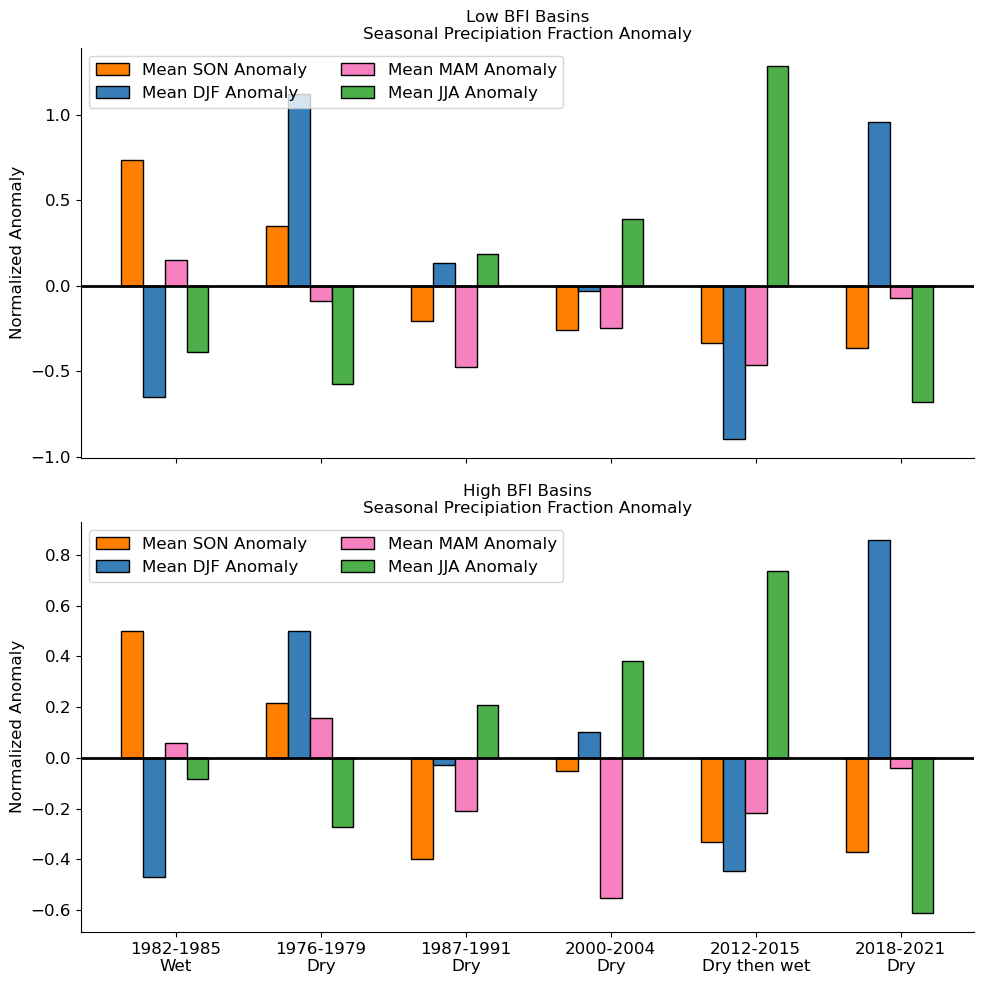

In [43]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10), tight_layout=True, sharex=True)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
x1=[0,1,2,3,4,5]
x2 = [0.15,1.15,2.15,3.15,4.15,5.15]
x3 = [0.3,1.3,2.3,3.3,4.3,5.3]
x4 = [0.45,1.45,2.45,3.45,4.45,5.45]
labels=['Low BFI Basins', 'High BFI Basins']
location = [x1,x2,x3,x4]
ds_list = [white_river_prism_season_norm,animas_river_prism_season_norm]
for i,site in enumerate(['09361500','09304500']):
    ds = ds_list[i]
    fall_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==10).mean().values
        ]
    winter_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==1).mean().values
        ]
    spring_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==4).mean().values
        ]
    summer_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==7).mean().values
        ]
    
    ax=axs[i]

    fall = ax.bar(x=location[0],
        height=fall_means, width=0.15, label='Mean SON Anomaly',color=CB_color_cycle[1], ec='k')

    winter = ax.bar(x=location[1],
        height=winter_means, width=0.15, label='Mean DJF Anomaly',color=CB_color_cycle[0], ec='k')

    spring = ax.bar(x=location[2],
        height=spring_means, width=0.15, label='Mean MAM Anomaly',color=CB_color_cycle[3], ec='k')

    summer = ax.bar(x=location[3],
        height=summer_means,width=0.15, label='Mean JJA Anomaly',color=CB_color_cycle[2], ec='k')

    # Stylize
    xticks = [0.3,1.3,2.3,3.3,4.3,5.3]
    xticklabels = [
                    '1982-1985\nWet',
                    '1976-1979\nDry',
                    '1987-1991\nDry',
                    '2000-2004\nDry',
                    '2012-2015\nDry then wet',
                    '2018-2021\nDry']
    title = f'{labels[i]}\nSeasonal Precipiation Fraction Anomaly'
    xlabel = ''
    ylabel =  'Normalized Anomaly'
    
    stylize_axes(ax, title, xlabel, ylabel, xticks, xticklabels, )
    ax.legend(ncols=2,loc='upper left')
    ax.axhline(0,color='k',lw=2)

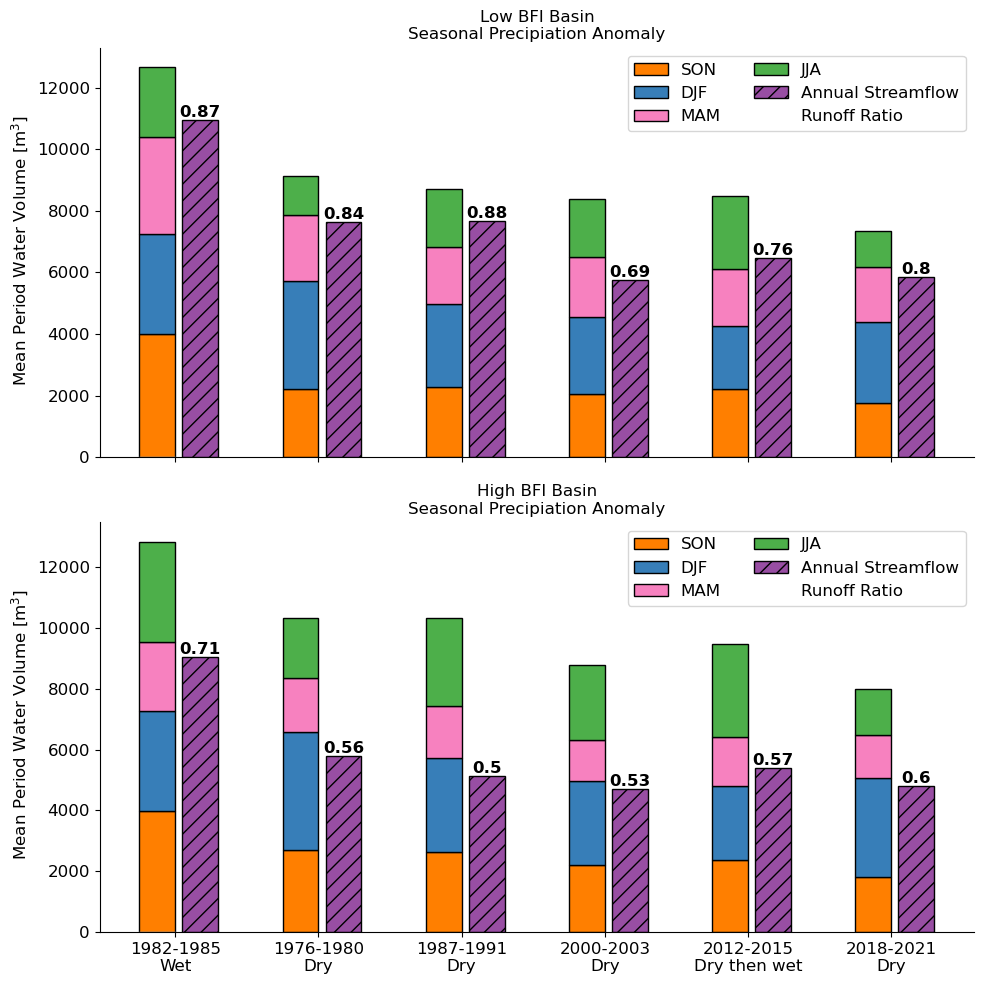

In [44]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10), tight_layout=True, sharex=True)
CB_color_cycle = [ '#ff7f00', '#377eb8', '#f781bf',
                  '#4daf4a','#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
x1=[0,1,2,3,4,5]
x2 = [0.3,1.3,2.3,3.3,4.3,5.3]
x3 = [0.3,1.3,2.3,3.3,4.3,5.3]
x4 = [0.45,1.45,2.45,3.45,4.45,5.45]
labels=['Low BFI Basin', 'High BFI Basin']
ds_list = [white_river_prism_season,animas_river_prism_season]
location = [x1,x2,x3,x4]
for i,site in enumerate(['09361500','09304500']):
    ds = ds_list[i]
    streamflow_means = [
            (streamflow_df[[site,'dowy']].loc[dt.date(1981,10,1):dt.date(1985,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1976,10,1):dt.date(1979,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1986,10,1):dt.date(1991,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(1999,10,1):dt.date(2004,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2015,9,30)].groupby('dowy').mean()*0.0283).sum().values[0],
            (streamflow_df[[site,'dowy']].loc[dt.date(2017,10,1):dt.date(2021,9,30)].groupby('dowy').mean()*0.0283).sum().values[0]
        ]

    fall_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==10).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==10).mean().values
        ]
    winter_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==1).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==1).mean().values
        ]
    spring_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==4).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==4).mean().values
        ]
    summer_means = [
            ds.loc[dt.date(1981,10,1):dt.date(1985,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(1976,10,1):dt.date(1979,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(1986,10,1):dt.date(1991,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(1999,10,1):dt.date(2004,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(2011,10,1):dt.date(2015,9,30)].where(ds.month.dt.month==7).mean().values,
            ds.loc[dt.date(2017,10,1):dt.date(2021,9,30)].where(ds.month.dt.month==7).mean().values
        ]
    weights_dict = dict(zip(['SON','DJF','MAM','JJA'],[fall_means,winter_means,spring_means,summer_means]))
    precip_sums = pd.DataFrame(([fall_means,winter_means,spring_means,summer_means])).sum(axis=0).values
    periods = [
                    '1982-1985\nWet',
                    '1976-1979\nDry',
                    '1987-1991\nDry',
                    '2000-2004\nDry',
                    '2012-2015\nDry then wet',
                    '2018-2021\nDry']
    width = 0.25
    bottom = np.zeros(6)
    color=0
    ax=axs[i]
    for k, v in weights_dict.items():
        p = ax.bar(periods, v, width, label=k, bottom=bottom, ec='k', color=CB_color_cycle[color])
        bottom += v
        color+=1
        # create plot for each site

    q_bar = ax.bar(x=location[1],
        height=streamflow_means, width=0.25, label='Annual Streamflow',color=CB_color_cycle[5], ec='k', hatch='//')
    ax.bar(x=[0],
        height=[0], width=0.25, label='Runoff Ratio',color='white', ec='white')
    p_over_q_prism = np.array(streamflow_means)/precip_sums
    # Put Q/P labels over each bar
    ax.bar_label(q_bar, labels=[round(val,2) for val in p_over_q_prism], size=12, weight='bold')
    ax.set_xticks([0.125,1.125,2.125,3.125,4.125,5.125])
    ax.set_xticklabels([
                    '1982-1985\nWet',
                    '1976-1979\nDry',
                    '1987-1991\nDry',
                    '2000-2004\nDry',
                    '2012-2015\nDry then wet',
                    '2018-2021\nDry'], rotation=0)
    # Stylization
    title = f'{labels[i]}\nSeasonal Precipiation Anomaly'
    xlabel = ''
    ylabel = ' Mean Period Water Volume [m$^3$]'
    xticks = [0.125,1.125,2.125,3.125,4.125,5.125]
    xticklabels = [
                    '1982-1985\nWet',
                    '1976-1980\nDry',
                    '1987-1991\nDry',
                    '2000-2003\nDry',
                    '2012-2015\nDry then wet',
                    '2018-2021\nDry']
    yticks = np.linspace(0, 13000, 5)
    yticklabels = yticks
    stylize_axes(ax, title, xlabel, ylabel, xticks, xticklabels)
    ax.legend(ncols=2,loc='upper right')
# fig.text(-0.02, 0.5, 'Volume m$^3$', va='center', rotation='vertical')
plt.savefig('./figures/seasonal_precip.png', dpi=300)

### Plot comparing Annual Runoff Ratios to Annual Precipitation

In [41]:
import scipy.stats as stats

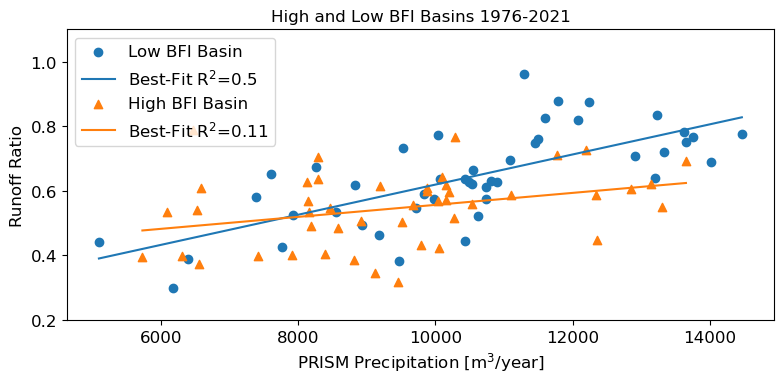

In [55]:
fig, ax = plt.subplots(nrows=1, figsize=(8,4), tight_layout=True, sharex=True)
symbols=['o','^']
for i,site in enumerate(['09361500','09304500']):
    streamflow_means = (streamflow_df[[site,'WY']].groupby('WY').sum()*0.0283)
         
    prism_mean = prism_anomaly.loc[1976:2021][column_dict[site]]
           
    p_over_q_prism = (streamflow_means.loc[1976:2021].T)/(prism_mean.loc[1976:2021].T)-0.1
    
    slope, intercept,r,std,p = stats.linregress(prism_mean,p_over_q_prism, alternative='greater')

    ax.scatter(prism_mean,p_over_q_prism,marker=symbols[i], label = labels[i])
    ax.plot([prism_mean.min(),prism_mean.max()],[slope*prism_mean.min() + intercept,slope*prism_mean.max()+intercept], label=f'Best-Fit R$^2$={round(r**2,2)}')
    ax.set_title(f'High and Low BFI Basins 1976-2021')
    ax.set_xlabel('PRISM Precipitation [m$^3$/year]')
    ax.set_ylabel('Runoff Ratio')
    ax.legend(loc='upper left')
    ax.set_ylim(0.2,1.1)

### Plot as above with 4-year running average

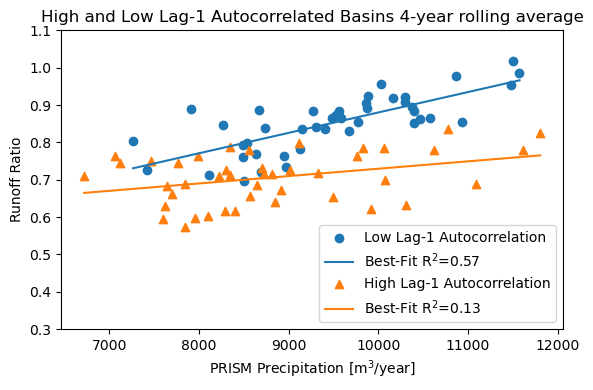

In [358]:
fig, ax = plt.subplots(nrows=1, figsize=(6,4), tight_layout=True, sharex=True)
symbols=['o','^']
for i,site in enumerate(['09361500','09304500']):
    streamflow_means = (streamflow_df[[site,'WY']].groupby('WY').sum()*0.0283).rolling(4).mean()
         
    prism_mean = prism_anomaly.loc[1976:2021][column_dict[site]].rolling(4).mean()
           
    p_over_q_prism = ((streamflow_means.loc[1976:2021].T)/(prism_mean.loc[1976:2021].T)).T
    
    slope, intercept,r,std,p = stats.linregress(prism_mean.loc[1979:2021],p_over_q_prism.loc[1979:2021][site], alternative='greater')

    ax.scatter(prism_mean,p_over_q_prism,marker=symbols[i], label = labels[i])
    ax.plot([prism_mean.min(),prism_mean.max()],[slope*prism_mean.min() + intercept,slope*prism_mean.max()+intercept], label=f'Best-Fit R$^2$={round(r**2,2)}')
    ax.set_title(f'High and Low Lag-1 Autocorrelated Basins 4-year rolling average')
    ax.set_xlabel('PRISM Precipitation [m$^3$/year]')
    ax.set_ylabel('Runoff Ratio')
    ax.legend()
    ax.set_ylim(0.3,1.1)

### Distribution of BFI Basin

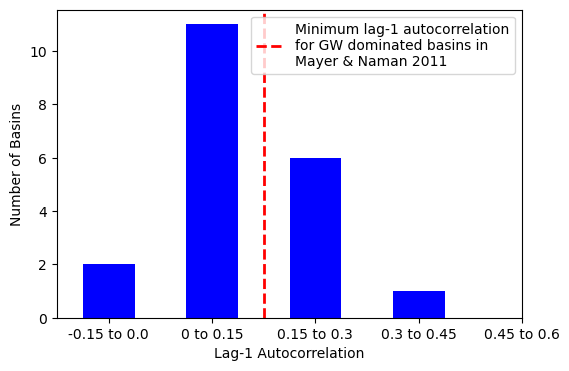

In [502]:
# fig, ax = plt.subplots()
out = pd.cut(np.array(list(lag_1_autocorr.values())), bins=[-0.15,0, 0.15,0.3,0.45], include_lowest=True)
ax = out.value_counts().plot.bar(rot=0, color="b", figsize=(6,4), label='')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([f'{val} to {round(val+0.15,2)}' for val in [-0.15,0, 0.15,0.3,0.45]])
plt.axvline(1.5, lw=2,ls='--',color='r', label='Minimum lag-1 autocorrelation\nfor GW dominated basins in\nMayer & Naman 2011')
plt.ylabel("pct")
plt.xlabel('Lag-1 Autocorrelation')
plt.ylabel('Number of Basins')
plt.legend()

In [114]:
prism_anomaly

NameError: name 'prism_anomaly' is not defined

### High vs Low Autocorrelated Basins, What can we see?

In [757]:
# fig, axs = plt.subplots(nrows=len(northern_names))
df = hcdn_q_spring_summer_sum_ds.to_dataframe().reset_index().set_index('year')
df_list= [df[df['site_no']==site].rename(columns={'00060_Mean':site})[site] for site in df['site_no'].unique()]
hcdn_annual_streamflow_df = pd.concat(df_list, axis=1)
hcdn_annual_streamflow_df[hcdn_annual_streamflow_df==0] = np.nan


,09034900,09035800,09047700,09065500,09066000,09066200,09066300,09081600,09107000,09112500,...,09119000,09124500,09132500,09146200,09147500,09165000,09239500,09304500,09352900,09361500
year,,,,,,,,,,,,,,,,,,,,,
1936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136722.0,...,NaN,NaN,154047.0,NaN,56224.0,NaN,174181.0,159203.0,NaN,221071.0
1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92620.0,...,NaN,NaN,134135.0,NaN,64109.0,NaN,98865.0,115447.0,NaN,230236.0
1938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123026.0,...,58671.0,105158.0,208344.0,NaN,124492.0,NaN,159806.0,198285.0,NaN,318139.0
1939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77726.0,...,37208.0,56385.0,115817.0,NaN,57637.0,NaN,125450.0,129779.0,NaN,159907.0
1940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57921.0,...,14087.0,50001.0,107541.0,NaN,65299.0,NaN,113428.0,126311.0,NaN,144939.0


In [781]:
hcdn_annual_streamflow_df_subset = hcdn_annual_streamflow_df.loc[1950:]
autocorr = hcdn_annual_streamflow_df_subset.rolling(20).apply(lambda x: x.autocorr(), raw=False)
variance = hcdn_annual_streamflow_df_subset.rolling(20).apply(lambda x: (x.var()), raw=False)/hcdn_annual_streamflow_df.var(axis=0)
cv = hcdn_annual_streamflow_df_subset.rolling(20).apply(lambda x: (x.var()), raw=False)
mean = hcdn_annual_streamflow_df_subset.rolling(20).apply(lambda x: (x.mean()), raw=False)

<Axes: xlabel='year'>

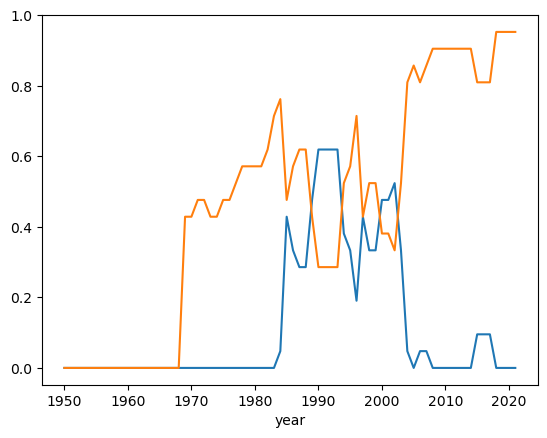

In [786]:
(((autocorr>=0.3).sum(axis=1))/len(autocorr.columns)).plot(label='persistent')
(((autocorr<0.3).sum(axis=1))/len(autocorr.columns)).plot(label='anti-persistent')